<a href="https://colab.research.google.com/github/KevinrealG/Series_de_tiempo/blob/main/02_Aplying_arima_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Datos y Librerias

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')
from datetime import date

from sklearn.linear_model import LinearRegression

<ipython-input-1-515b416831b3>:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


Fremont Bridge Sidewalks, south of N 34th St
!curl -o FremontBridge.csv https://data.seattle.gov/api/views/65db-xm6k/rows.csv?accessType=DOWNLOAD

The Fremont Bridge Bicycle Counter began operation in October 2012 and records the number of bikes that cross the bridge using the pedestrian/bicycle pathways. Inductive loops on the east and west pathways count the passing of bicycles regardless of travel direction. The data consists of a date/time field: Date, east pathway count field: Fremont Bridge NB, and west pathway count field: Fremont Bridge SB. The count fields represent the total bicycles detected during the specified one hour period. Direction of travel is not specified, but in general most traffic in the Fremont Bridge NB field is travelling northbound and most traffic in the Fremont Bridge SB field is travelling southbound.


In [2]:
data = pd.read_csv('https://data.seattle.gov/resource/65db-xm6k.csv', index_col='date',parse_dates=True)

In [3]:
data.head()

,fremont_bridge,fremont_bridge_sb,fremont_bridge_nb
date,,,
2023-11-30 23:00:00,9,6,3
2023-11-30 22:00:00,21,4,17
2023-11-30 21:00:00,21,11,10
2023-11-30 20:00:00,35,14,21
2023-11-30 19:00:00,67,19,48


In [4]:
# prompt: sort by date

data.sort_index()


,fremont_bridge,fremont_bridge_sb,fremont_bridge_nb
date,,,
2023-10-20 08:00:00,249,89,160
2023-10-20 09:00:00,156,46,110
2023-10-20 10:00:00,97,34,63
2023-10-20 11:00:00,86,40,46
2023-10-20 12:00:00,100,40,60
...,...,...,...
2023-11-30 19:00:00,67,19,48
2023-11-30 20:00:00,35,14,21
2023-11-30 21:00:00,21,11,10


Text(0, 0.5, 'Number of bikes')

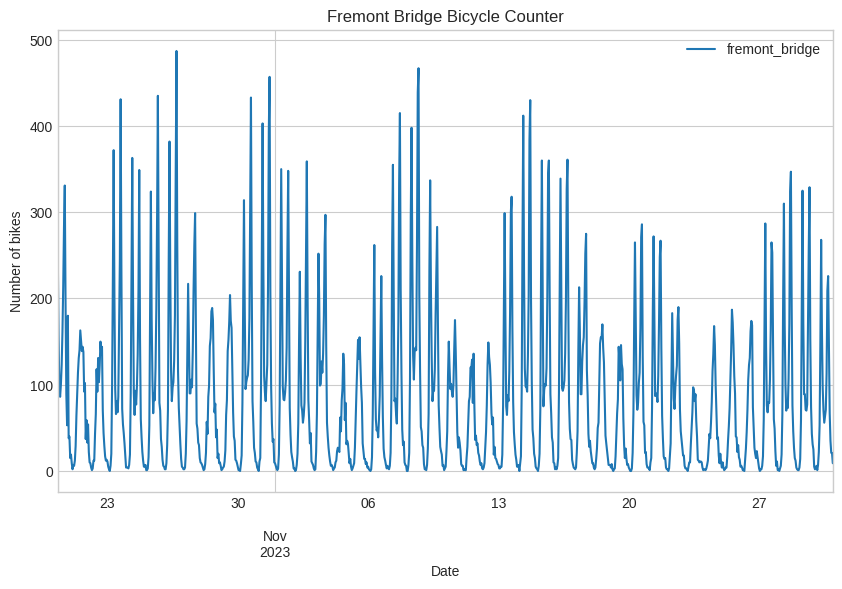

In [5]:
# prompt: plot fremont_bridge data with titles

data[["fremont_bridge"]].plot(title='Fremont Bridge Bicycle Counter', figsize=(10, 6))
plt.xlabel('Date')
plt.ylabel('Number of bikes')


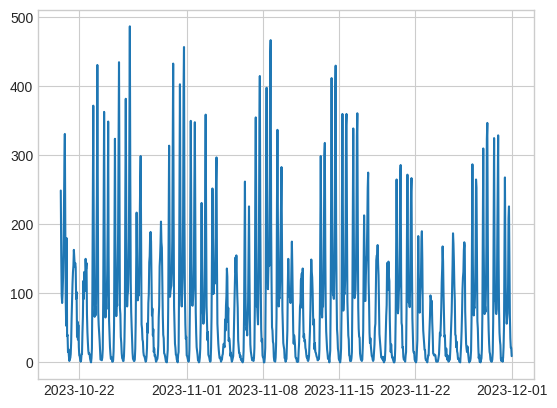

In [6]:
plt.plot(data['fremont_bridge'])

# Arima

Flow Diagram for ARIMA Time Series Analysis:
1. Data Preparation:
Gather the time series data and ensure it's in a suitable format.
Check for missing values and handle them if present.
2. Check for Seasonality:
Visualize the time series to observe any repetitive patterns or cycles. Use a decomposition plot to identify trend, seasonality, and residual components.
3. Assess Stationarity:
Plot the time series to visually inspect trends, rolling statistics, and stationarity.
Perform the Augmented Dickey-Fuller (ADF) test to check for stationarity.
4. Differencing:
Apply differencing to achieve stationarity if the series is non-stationary.
Check stationarity after differencing using the ADF test.
5. ACF and PACF Analysis:
Examine the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) of the differenced series to determine the orders (p, d, q) for ARIMA.
6. Fit ARIMA Model:
Fit the ARIMA model to the differenced series using the determined orders (p, d, q).
Generate forecasts in the differenced space.
7. Inverse Differencing for Interpretation:
Invert the differencing process to translate the forecasts back to the original scale.
Apply cumulative sum to the forecasted differences to obtain predictions in the original scale.
8. Evaluate and Refine:
Assess the model's performance using appropriate evaluation metrics (e.g., MAE, RMSE).
Refine the model if necessary by adjusting parameters and re-fitting.

In [7]:
import warnings
import itertools
import statsmodels.api as sm

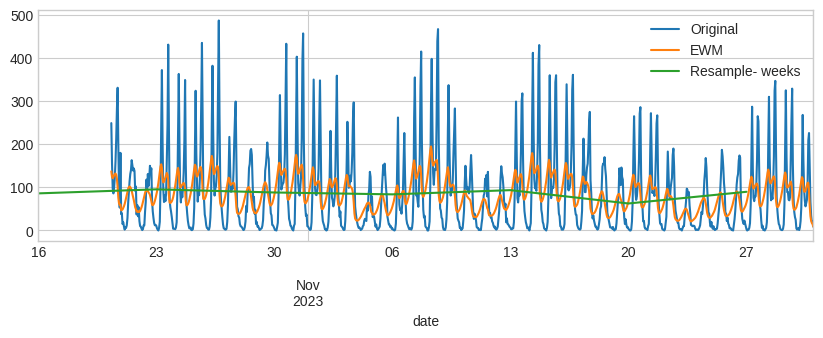

In [8]:
data["fremont_bridge"].plot(figsize=(10,3),label="Original")
data["fremont_bridge"].ewm(alpha=0.1).mean().plot(figsize=(10,3),label="EWM")
data["fremont_bridge"].resample("w").mean().plot(figsize=(10,3),label="Resample- weeks")
plt.legend()

In [9]:
from statsmodels.tsa.stattools import adfuller

# Perform Augmented Dickey-Fuller test
result_adf = adfuller(data["fremont_bridge"])  # Replace 'column_name' with the actual column containing your data

# Print the test statistic and p-value
print(f'Test Statistic: {result_adf[0]}')
print(f'P-value: {result_adf[1]}')
print(f'Critical Values: {result_adf[4]}')

Test Statistic: -2.5017456144284975
P-value: 0.1150501754444826
Critical Values: {'1%': -3.43706091543889, '5%': -2.8645028204932483, '10%': -2.568347558984588}


In [ ]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 2) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 2)
SARIMAX: (0, 0, 1) x (0, 1, 0, 2)
SARIMAX: (0, 1, 0) x (0, 1, 1, 2)
SARIMAX: (0, 1, 0) x (1, 0, 0, 2)


In [ ]:
y = data["fremont_bridge"].copy().sort_index()

<Axes: xlabel='date'>

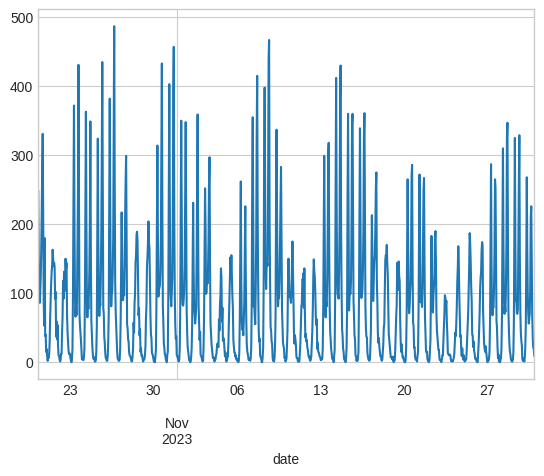

In [ ]:
y.plot()


In [ ]:
parameters,PARAMETERS,AIC=[],[],[]
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(y,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            results = mod.fit(disp=-1)
            #print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            parameters.append(param)
            PARAMETERS.append(param_seasonal)
            AIC.append(results.aic)
        except:
            continue
resultados=pd.DataFrame({"Tendencia":parameters,"Estacionalidad":PARAMETERS,"AIC":AIC})

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dat

In [ ]:
resultados

,Tendencia,Estacionalidad,AIC
0,"(0, 0, 0)","(0, 0, 0, 2)",12500.438877
1,"(0, 0, 0)","(0, 0, 1, 2)",12014.997480
2,"(0, 0, 0)","(0, 1, 0, 2)",11979.827197
3,"(0, 0, 0)","(0, 1, 1, 2)",11859.442403
4,"(0, 0, 0)","(1, 0, 0, 2)",11828.030143
...,...,...,...
59,"(1, 1, 1)","(0, 1, 1, 2)",10761.581281
60,"(1, 1, 1)","(1, 0, 0, 2)",10758.043488
61,"(1, 1, 1)","(1, 0, 1, 2)",10685.508920
62,"(1, 1, 1)","(1, 1, 0, 2)",11059.999028


In [ ]:
resultados[resultados["AIC"]==resultados["AIC"].min()]


,Tendencia,Estacionalidad,AIC
47,"(1, 0, 1)","(1, 1, 1, 2)",10589.097204


In [ ]:
mod = sm.tsa.statespace.SARIMAX(y,
                                order=(1, 0, 1),
                                seasonal_order=(1, 1, 1, 2),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

print(results.summary().tables[1])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5899      0.102      5.806      0.000       0.391       0.789
ma.L1          0.6319      0.096      6.588      0.000       0.444       0.820
ar.S.L2        0.1050      0.128      0.818      0.413      -0.147       0.357
ma.S.L2       -1.0000      5.591     -0.179      0.858     -11.958       9.958
sigma2      2423.2503   1.36e+04      0.179      0.858   -2.41e+04     2.9e+04


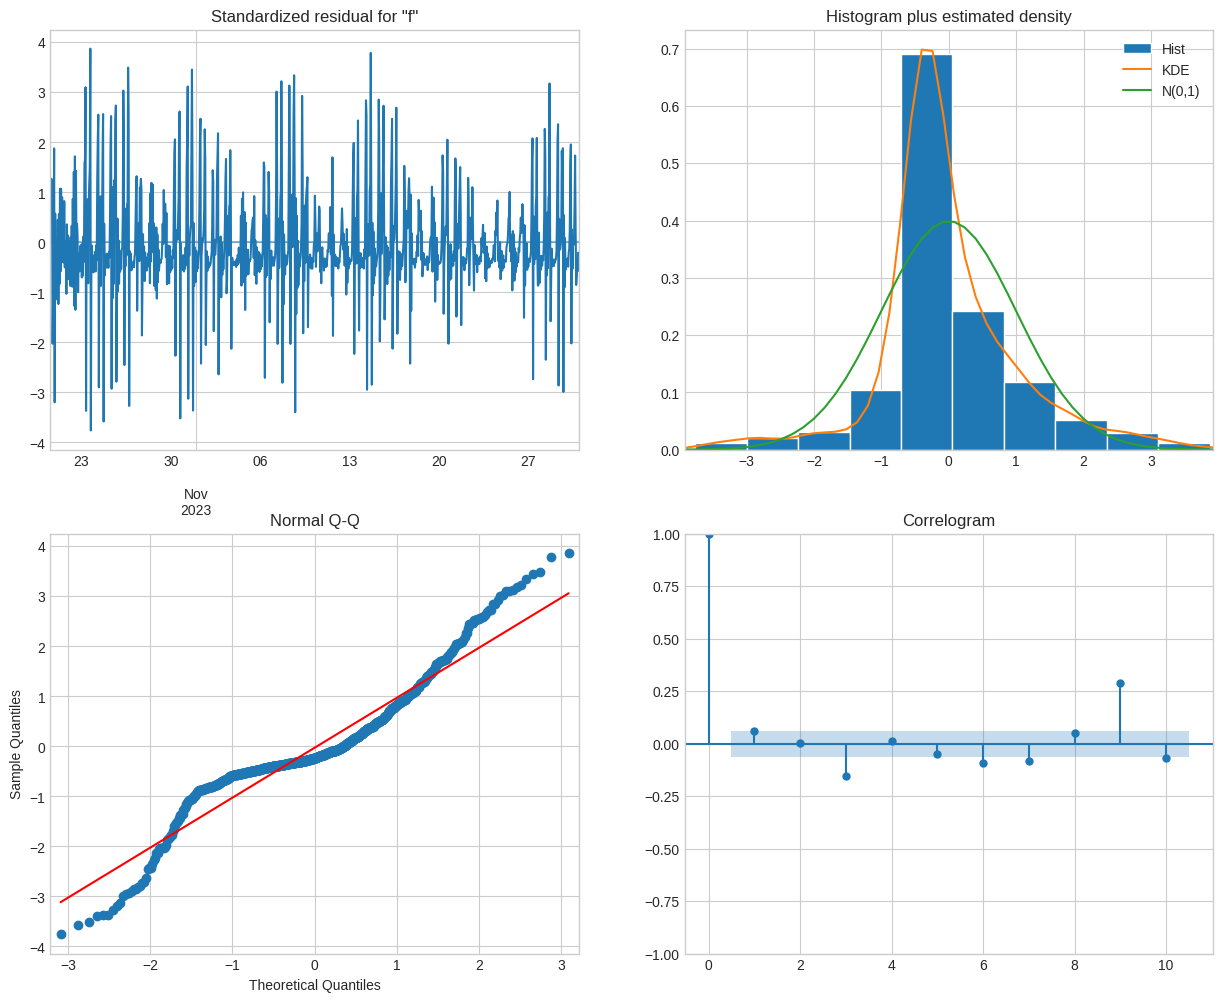

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2023-11-25 00:00:00'), dynamic=False)
pred_ci = pred.conf_int()


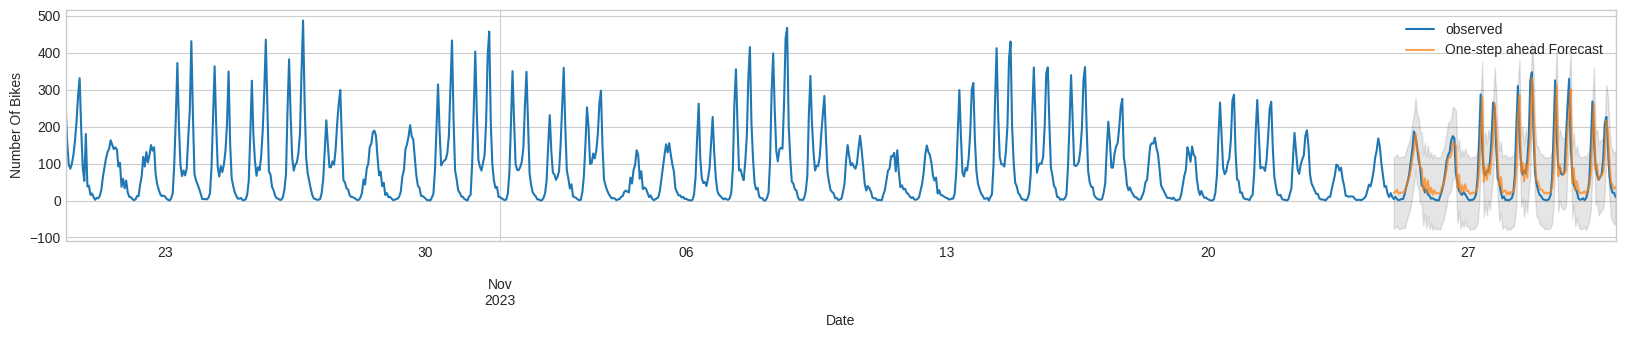

In [ ]:
ax = y.plot(label='observed',figsize=(20,3))
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.1)

ax.set_xlabel('Date')
ax.set_ylabel('Number Of Bikes')
plt.legend()

In [ ]:
from sklearn.metrics import r2_score, mean_squared_error
print("Root mean squared error =", np.sqrt(mean_squared_error(pred.predicted_mean,y["2023-11-25 00:00:00":])))
print("R2 score =", r2_score(pred.predicted_mean,y["2023-11-25 00:00:00":]))

Root mean squared error = 45.3763962338736
R2 score = 0.6072809342139673


In [ ]:
# prompt: calculate other metrics(mse, coefi_corr, rmse, r2) and save in a df and show df

df=pd.DataFrame({"metric":["Root mean squared error","R2 score"],"value":[np.sqrt(mean_squared_error(pred.predicted_mean,y["2023-11-25 00:00:00":])),r2_score(pred.predicted_mean,y["2023-11-25 00:00:00":])]})
df


,metric,value
0,Root mean squared error,45.376396
1,R2 score,0.607281


In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

result_est = seasonal_decompose(y, model='add')


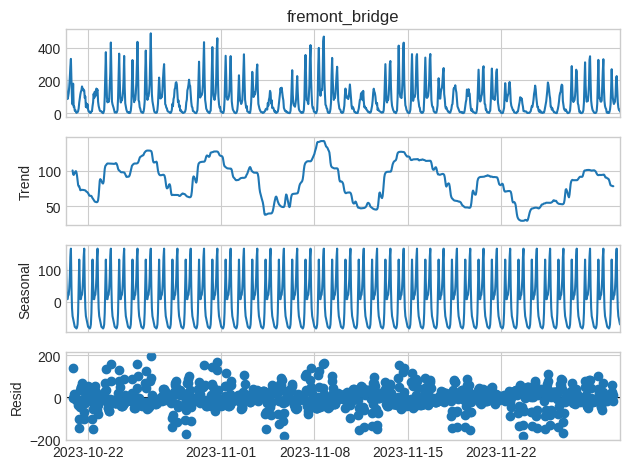

In [ ]:
result_est.plot()
plt.show()

### diferenciado

# LSTM

## Preparing Data

In [ ]:
y

In [ ]:
# transform data
raw_seq=np.array(y.values)


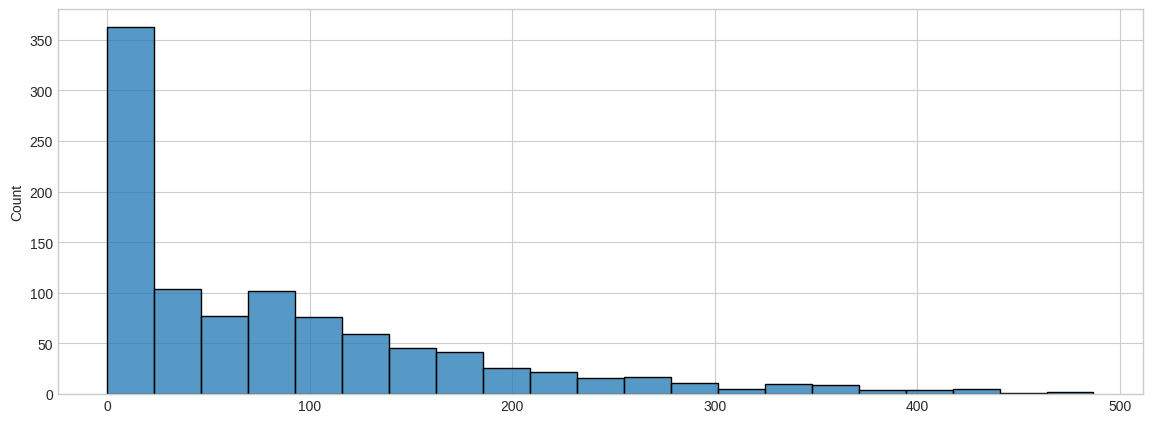

In [ ]:
plt.figure(figsize = (14,5))
sns.histplot(raw_seq)
plt.show()

### univariate data

In [ ]:
from numpy import array
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# choose a number of time steps
n_steps = 5
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# summarize the data
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)


In [ ]:
x_input = array(raw_seq[-6:-1])
print(x_input)
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat[0][0])
print(raw_seq[-1])

[144  67  35  21  21]
17.466358
9


## Model

In [ ]:
# Crear los conjuntos de entrenamiento y validación
train,validation=raw_seq[:-24],raw_seq[-24:]


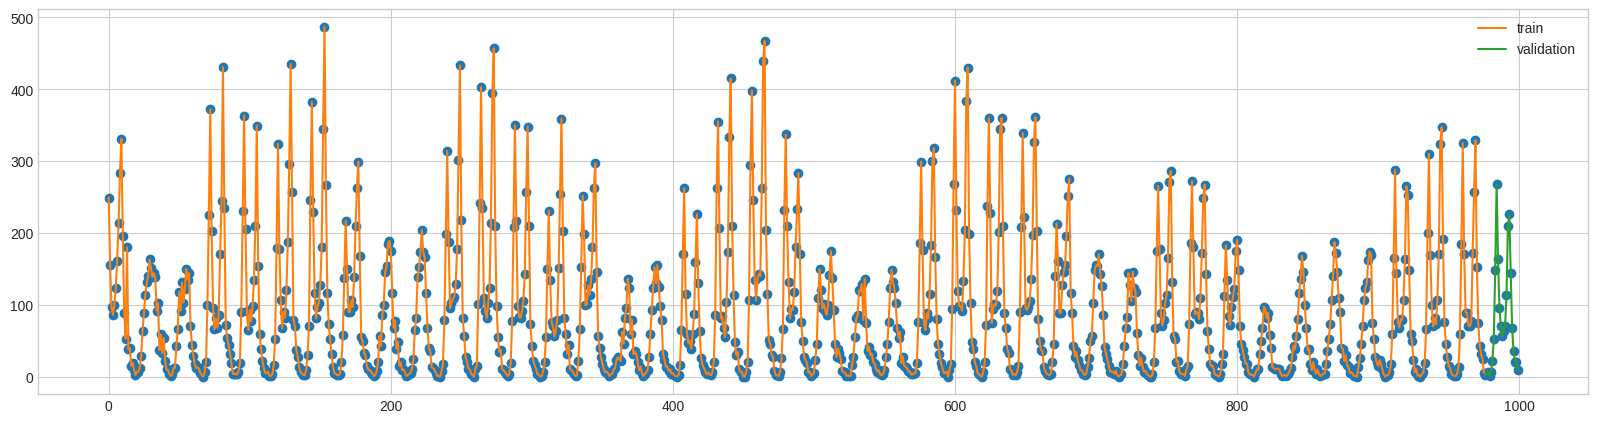

In [ ]:
plt.figure(figsize = (20,5))
plt.plot(raw_seq,marker="o",lw=0)
plt.plot(range(0,len(train),1),train,label="train")
plt.plot(range(len(train),len(raw_seq),1),validation,label="validation")
plt.legend()
plt.show()

In [ ]:
# choose a number of time steps
n_steps = 24
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)

In [ ]:
# Last 24 terms of your sequence for prediction
last_sequence = raw_seq[-n_steps:]  # Assuming `n_steps` is the number of steps for each sequence

# Predict the next 24 terms sequentially
predicted_sequence = []
for _ in range(24):
    # Reshape the last sequence for model input
    x_input = last_sequence[-n_steps:]
    x_input = x_input.reshape((1, n_steps, n_features))  # Assuming `n_features` is the number of features

    # Get the prediction for the next term
    yhat = model.predict(x_input, verbose=0)

    # Append the prediction to the predicted sequence
    predicted_sequence.append(yhat[0,0])  # Assuming the output shape is (1, 1)

    # Update the last sequence with the new prediction for the next iteration
    last_sequence = np.append(last_sequence, yhat[0,0])

# Print or use the predicted sequence for comparison
print("Predicted Sequence:", predicted_sequence)

Predicted Sequence: [4.8148212, 4.044262, 6.6000023, 13.432369, 25.963459, 46.946262, 81.53557, 130.49434, 177.06784, 127.87259, 73.532394, 48.910236, 40.29086, 48.32013, 72.25233, 113.024574, 162.95322, 196.1722, 177.97565, 154.33072, 116.76458, 56.288216, 37.75087, 39.9058]


## Evaluate model

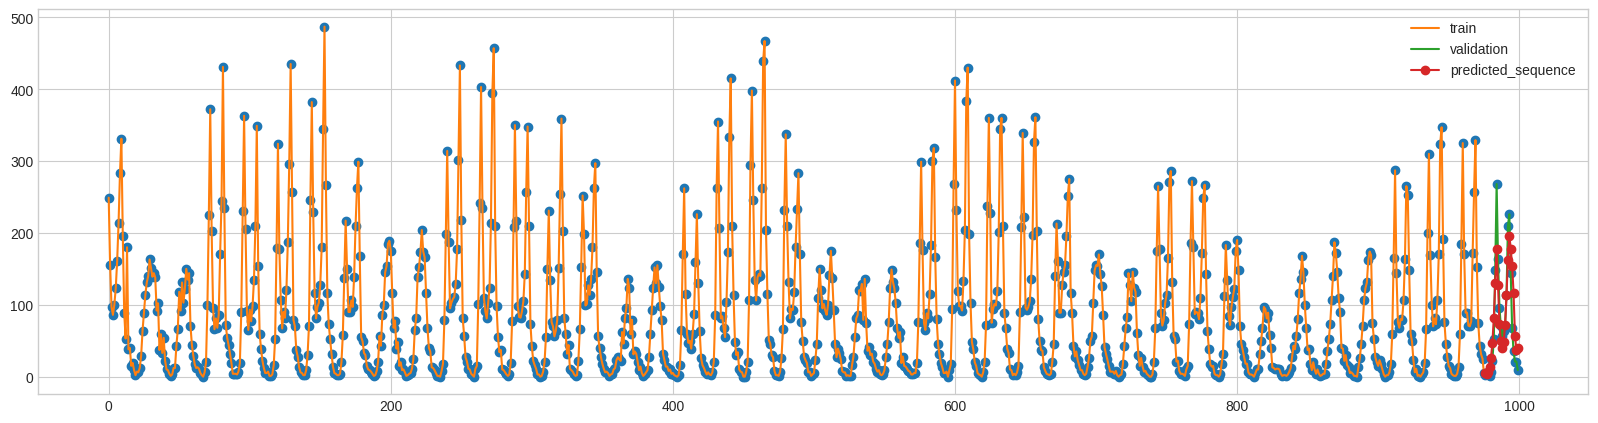

In [ ]:
plt.figure(figsize = (20,5))

plt.plot(raw_seq,marker="o",lw=0)
plt.plot(range(0,len(train),1),train,label="train")
plt.plot(range(len(train),len(raw_seq),1),validation,label="validation")
plt.plot(range(len(train),len(raw_seq),1),predicted_sequence,label="predicted_sequence",marker="o")
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
np.sqrt(mean_squared_error(predicted_sequence,validation))


37.73596932545464

In [ ]:
# prompt: evaluate model with metrics


df=pd.DataFrame({"metric":["Root mean squared error","R2 score"],"value":[np.sqrt(mean_squared_error(predicted_sequence,validation)),r2_score(predicted_sequence,validation)]})
df


,metric,value
0,Root mean squared error,37.735969
1,R2 score,0.597971
